In [2]:
import warnings
import numpy as np
from tensorflow.keras.models import load_model , Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img
import matplotlib.pyplot as plt
import cv2  
import scipy as sp
import tensorflow as tf
import os
from tqdm import tqdm
warnings.filterwarnings("ignore")


In [3]:
#identify classes
classes={0:"no_tumor" , 1:"glioma_tumor" , 2:"meningioma_tumor" , 3:"pituitary_tumor"}
#function to get code by name 
def get_code(name):
    for key , value in classes.items():
        if value ==name:
            break
    return key

#function to get name by code
def get_class(key):
    return classes[key]


#test
print("No_tumor :", get_code("no_tumor"))
print("0 :" ,get_class(0))

print("Glioma_Tumor :", get_code("Glioma_Tumor"))
print("1 :" ,get_class(1))

print("Meningioma_Tumor :", get_code("Meningioma_Tumor"))
print("2 :" ,get_class(2))

No_tumor : 0
0 : no_tumor
Glioma_Tumor : 3
1 : glioma_tumor
Meningioma_Tumor : 3
2 : meningioma_tumor


# Test 

In [4]:

#load model
model=load_model(r"D:\GP dataset\جاهز للتسليم\skin cancer\denseNetModel_brain_tumor.h5")


In [18]:
path=r"D:\GP dataset\جاهز للتسليم\brain tumor\Brain Tumor Classification (MRI)dataset\Testing\meningioma_tumor\image(35).jpg"
path.split("\\")[-2]

'meningioma_tumor'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


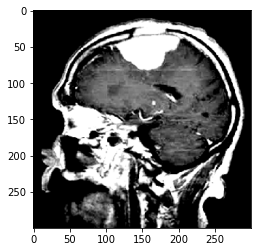

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


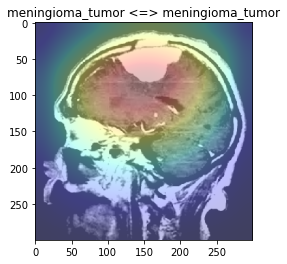

In [19]:


#do the image processing  on mri slice
generator=ImageDataGenerator(
        samplewise_std_normalization=True,
        samplewise_center=True)
image_size=300
image=load_img(path,grayscale=False, color_mode="rgb", target_size=(image_size, image_size), interpolation="nearest")


image=np.array(image)
image=np.expand_dims(image,axis=0)
#do the image processing  on mri slice
image_generator=generator.flow(image)
mri_slice=image_generator.__getitem__(0)[0]

##############show scan
plt.imshow(mri_slice)
plt.show()
########################

mri_slice=np.expand_dims(mri_slice, axis=0)
# print(mri_slice.shape)


#Show result 
pred=model.predict(image_generator)
get_class(np.argmax(pred))

#############################################################################################
#class activation map  to identify the what the model already show




label=get_code(path.split("\\")[-2]) #image label
#class activation map
cam_model=Model(inputs=model.inputs,outputs=(model.layers[-11].output , model.layers[-1].output))
# cam_model.summary()
# get weights
get_weights=cam_model.layers[-1].get_weights()[0]

# print(get_weights.shape)

features , results=cam_model.predict(mri_slice)
predication=np.argmax(results)
class_activation_weights=get_weights[:,predication]
features.shape

#zoom image 
class_activation_features=sp.ndimage.zoom(features.reshape(9, 9, 64), (300/9, 300/9, 1), order=2)

# print(class_activation_features.shape, class_activation_weights.shape)

cam_output=np.dot(class_activation_features ,class_activation_weights)


plt.imshow(cam_output ,  cmap='jet', alpha=0.5)
plt.imshow(mri_slice.reshape(300,300,3), alpha=0.5)
title=classes[predication]+" <=> "+ classes[label]
plt.title(title)

plt.savefig('diagnosis.png', bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 299.5, 299.5, -0.5)

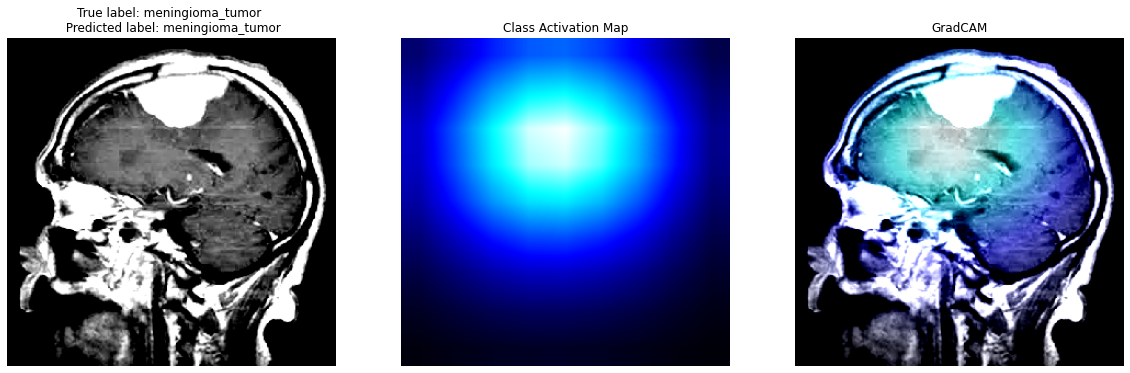

In [22]:
#gradcam

import tensorflow.keras.backend as K

def get_CAM(processed_image, actual_label, layer_index=-7 ):
    model_grad =Model(inputs=model.inputs,outputs=(model.layers[-11].output , model.layers[-1].output))

    
    with tf.GradientTape() as tape:
        conv_output_values, predictions = model_grad(mri_slice)

        # watch the conv_output_values
        tape.watch(conv_output_values)

        ## Use binary cross entropy loss
        ## actual_label is 0 if cat, 1 if dog
        # get prediction probability of dog
        # If model does well, 
        # pred_prob should be close to 0 if cat, close to 1 if dog
        pred_prob = predictions[:,1] 
        
        # make sure actual_label is a float, like the rest of the loss calculation
        actual_label = tf.cast(actual_label, dtype=tf.float32)
        
        # add a tiny value to avoid log of 0
        smoothing = 0.00001 
        
        # Calculate loss as binary cross entropy
        loss = -1 * (actual_label * tf.math.log(pred_prob + smoothing) + (1 - actual_label) * tf.math.log(1 - pred_prob + smoothing))
#         print(f"binary loss: {loss}")
#         print("predictions ", predictions)
    # get the gradient of the loss with respect to the outputs of the last conv layer
    grads_values = tape.gradient(loss, conv_output_values)
    grads_values = K.mean(grads_values, axis=(0,1,2))
    
    conv_output_values = np.squeeze(conv_output_values.numpy())
    grads_values = grads_values.numpy()
    
    # weight the convolution outputs with the computed gradients
    for i in range(64): 
        conv_output_values[:,:,i] *= grads_values[i]
    heatmap = np.mean(conv_output_values, axis=-1)
    
    heatmap = np.maximum(heatmap, 0)
    heatmap /= heatmap.max()
    
    del model_grad, conv_output_values, grads_values, loss
   
    return heatmap


index=1
sample_image_processed = mri_slice
    
    
pred_label = np.argmax(model.predict(sample_image_processed), axis=-1)[0]

    
heatmap = get_CAM(mri_slice, label, layer_index=-7)
heatmap = cv2.resize(heatmap, (300, 300))
heatmap = heatmap *255
heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)


converted_img = mri_slice
super_imposed_image = cv2.addWeighted(converted_img.reshape(300,300,3), 0.8, heatmap.astype('float32'), 2e-3, 0.0)

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True,figsize=(20,12))

ax0.imshow(converted_img.reshape(300,300,3))
ax0.set_title(f"True label: {classes[label]} \n Predicted label: {classes[(pred_label)]}")
ax0.axis('off')

ax1.imshow(heatmap)
ax1.set_title("Class Activation Map")
ax1.axis('off')

ax2.imshow(super_imposed_image)
ax2.set_title("GradCAM")
ax2.axis('off')

  


In [14]:
converted_img.shape

(1, 300, 300, 3)

In [6]:
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 306, 306, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 150, 150, 64) 9408        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

conv4_block30_1_conv (Conv2D)   (None, 18, 18, 128)  151552      conv4_block30_0_relu[0][0]       
__________________________________________________________________________________________________
conv4_block30_1_bn (BatchNormal (None, 18, 18, 128)  512         conv4_block30_1_conv[0][0]       
__________________________________________________________________________________________________
conv4_block30_1_relu (Activatio (None, 18, 18, 128)  0           conv4_block30_1_bn[0][0]         
__________________________________________________________________________________________________
conv4_block30_2_conv (Conv2D)   (None, 18, 18, 32)   36864       conv4_block30_1_relu[0][0]       
__________________________________________________________________________________________________
conv4_block30_concat (Concatena (None, 18, 18, 1216) 0           conv4_block29_concat[0][0]       
                                                                 conv4_block30_2_conv[0][0]       
__________

conv5_block14_concat (Concatena (None, 9, 9, 1344)   0           conv5_block13_concat[0][0]       
                                                                 conv5_block14_2_conv[0][0]       
__________________________________________________________________________________________________
conv5_block15_0_bn (BatchNormal (None, 9, 9, 1344)   5376        conv5_block14_concat[0][0]       
__________________________________________________________________________________________________
conv5_block15_0_relu (Activatio (None, 9, 9, 1344)   0           conv5_block15_0_bn[0][0]         
__________________________________________________________________________________________________
conv5_block15_1_conv (Conv2D)   (None, 9, 9, 128)    172032      conv5_block15_0_relu[0][0]       
__________________________________________________________________________________________________
conv5_block15_1_bn (BatchNormal (None, 9, 9, 128)    512         conv5_block15_1_conv[0][0]       
__________

Total params: 83,544,132
Trainable params: 81,814,468
Non-trainable params: 1,729,664
__________________________________________________________________________________________________


In [ ]:
########################   ((((((((i will removed it after retrain with the right dictionary on kaggle))))))))   ########################
#read whole test set

#read
data_path=r"D:\GP dataset\جاهز للتسليم\brain tumor\Brain Tumor Classification (MRI)dataset\Testing"
folders=os.listdir(data_path)
print ("classes : ", folders)


# configration lists for read in it
glioma_tumor_scans=[]
glioma_tumor_labels=[]

meningioma_tumor_scans=[]
meningioma_tumor_labels=[]

pituitary_tumor_scans=[]
pituitary_tumor_labels=[]


non_tumor_scans=[]
non_tumor_labels=[]

# read brain glioma tumor scans
glioma_tumor_scans,glioma_tumor_labels=[plt.imread(data_path+"/glioma_tumor/"+image) for image in tqdm(os.listdir(data_path+"/glioma_tumor"))],["Glioma Tumor" for image in tqdm(os.listdir(data_path+"/glioma_tumor"))]
print("brain glioma tumor scans number : ", len(glioma_tumor_scans))
print("brain glioma tumor labels number : ", len(glioma_tumor_labels))

 

# read brain meningioma tumor scans
meningioma_tumor_scans,meningioma_tumor_labels=[plt.imread(data_path+"/meningioma_tumor/"+image) for image in tqdm(os.listdir(data_path+"/meningioma_tumor"))],["Meningioma Tumor" for image in tqdm(os.listdir(data_path+"/meningioma_tumor"))]
print("brain meningioma tumor scans number : ", len(meningioma_tumor_scans))
print("brain meningioma tumor labels number : ", len(meningioma_tumor_labels))

# read brain tumor scans
pituitary_tumor_scans,pituitary_tumor_labels=[plt.imread(data_path+"/pituitary_tumor/"+image) for image in tqdm(os.listdir(data_path+"/pituitary_tumor"))],["Pituitary Tumor" for image in tqdm(os.listdir(data_path+"/pituitary_tumor"))]
print("brain pituitary tumor scans number : ", len(pituitary_tumor_scans))
print("brain pituitary tumor labels number : ", len(pituitary_tumor_labels))

# read non tumor scans
non_tumor_scans , non_tumor_labels=[plt.imread(data_path+"/no_tumor/"+image) for image in tqdm(os.listdir(data_path+"/no_tumor"))], ["Non Tumor" for image in tqdm(os.listdir(data_path+"/no_tumor"))]
print("non tumor scans number : ", len(non_tumor_scans))
print("non tumor labels number : ", len(non_tumor_labels))


# global image size
ImageSize=300

#resize tumor scans
glioma_tumor_scans=[cv2.resize(image, (ImageSize,ImageSize)) for image in glioma_tumor_scans]


#resize tumor scans
meningioma_tumor_scans=[cv2.resize(image, (ImageSize,ImageSize)) for image in meningioma_tumor_scans]


#resize tumor scans
pituitary_tumor_scans=[cv2.resize(image, (ImageSize,ImageSize)) for image in pituitary_tumor_scans]


#resize non tumor scans
non_tumor_scans=[cv2.resize(image, (ImageSize,ImageSize)) for image in non_tumor_scans]

#prepare Dataset

Scans=[]
Labels=[]


#combine scans
Scans.extend(glioma_tumor_scans)
Scans.extend(meningioma_tumor_scans)
Scans.extend(pituitary_tumor_scans)
Scans.extend(non_tumor_scans)

#combine labels
Labels.extend(glioma_tumor_labels)
Labels.extend(meningioma_tumor_labels)
Labels.extend(pituitary_tumor_labels)
Labels.extend(non_tumor_labels)

#converte to array 
Scans=np.array(Scans)
Labels=np.array(Labels)


print("Scans shape: ", Scans.shape)
print("Labels shape: ", Labels.shape)


#labels configuration
Labels=[get_code(label) for label in Labels]
Labels


import tensorflow as tf
Labels=tf.keras.utils.to_categorical(Labels, num_classes=4, dtype='float32')

print(Labels.shape)


#do the image processing  on mri slices
generator=ImageDataGenerator(
        samplewise_std_normalization=True,
        samplewise_center=True)

test_generator=generator.flow(Scans, Labels , batch_size=5)

#load model
model=load_model(r"D:\GP dataset\جاهز للتسليم\brain tumor\val acc 979\denseNetModel.h5")

#do test on all testset 
model.evaluate(test_generator)